In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color

%matplotlib inline

In [2]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True).astype('float32')
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def get_final_matrices(n_train = None, n_test = None):
    x_boys_train = get_images_matrix('boys_train.csv', 'boys', n_train)
    x_boys_test = get_images_matrix('boys_test.csv', 'boys', n_test)
    x_girls_train = get_images_matrix('girls_train.csv', 'girls', n_train)
    x_girls_test = get_images_matrix('girls_test.csv', 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

In [3]:
x_train, x_test, y_train, y_test = get_final_matrices()

In [4]:
check_mem()

[('x_train', 2400000112), ('x_test', 600000112), ('y_train', 160096), ('y_test', 40096), ('check_mem', 136), ('get_file_list', 136), ('read_image_and_resize', 136), ('read_images_4d_array', 136), ('get_images_matrix', 136), ('get_all_pixels', 136), ('get_final_matrices', 136), ('pd', 80), ('np', 80), ('plt', 80), ('transform', 80), ('color', 80)]


## Neural Network / Multi-Layer Perceptron (MLP)

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [24]:
batch_size = 128
epochs = 20

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

20000 train samples
5000 test samples


In [25]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(30000,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               15360512  
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
__________

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',#RMSprop(),
              metrics=['accuracy'])

In [27]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 27s 1ms/step - loss: 1.0891 - acc: 0.5110 - val_loss: 0.6863 - val_acc: 0.5474
Epoch 2/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.7025 - acc: 0.5261 - val_loss: 0.6876 - val_acc: 0.4892
Epoch 3/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.6790 - acc: 0.5537 - val_loss: 0.6635 - val_acc: 0.5978
Epoch 4/20
20000/20000 [==============================] - 27s 1ms/step - loss: 0.6522 - acc: 0.6117 - val_loss: 0.6083 - val_acc: 0.6662
Epoch 5/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.6271 - acc: 0.6526 - val_loss: 0.5936 - val_acc: 0.6918
Epoch 6/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.6106 - acc: 0.6742 - val_loss: 0.6066 - val_acc: 0.6762
Epoch 7/20
20000/20000 [==============================] - 28s 1ms/step - loss: 0.6004 - acc: 0.6819 - val_loss: 0.5836 - val_acc:

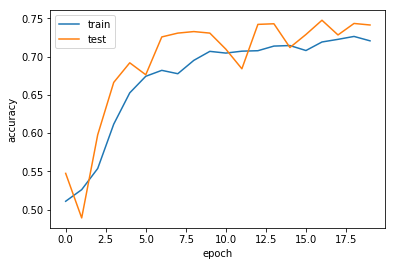

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')

## Convolutional Neural Network (CNN)

In [29]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [30]:
K.image_data_format()

'channels_last'

In [31]:
# input image dimensions
img_rows, img_cols, channels = 100, 100, 3

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, channels)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               18874496  
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
__________

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 224s 11ms/step - loss: 0.6638 - acc: 0.7125 - val_loss: 0.4711 - val_acc: 0.7826
Epoch 2/20
20000/20000 [==============================] - 239s 12ms/step - loss: 0.4299 - acc: 0.8005 - val_loss: 0.4422 - val_acc: 0.7858
Epoch 3/20
20000/20000 [==============================] - 265s 13ms/step - loss: 0.3636 - acc: 0.8402 - val_loss: 0.3910 - val_acc: 0.8260
Epoch 4/20
20000/20000 [==============================] - 275s 14ms/step - loss: 0.2974 - acc: 0.8728 - val_loss: 0.3776 - val_acc: 0.8370
Epoch 5/20
20000/20000 [==============================] - 259s 13ms/step - loss: 0.2323 - acc: 0.9066 - val_loss: 0.4104 - val_acc: 0.8208
Epoch 6/20
20000/20000 [==============================] - 252s 13ms/step - loss: 0.1848 - acc: 0.9280 - val_loss: 0.4115 - val_acc: 0.8338
Epoch 7/20
20000/20000 [==============================] - 252s 13ms/step - loss: 0.1341 - acc: 0.9501 - val_loss: 0.4